features: ux, uy, cp, nu_tilde, eddie_viscosity, implicit_distance
target: ux, uy, cp

In [23]:
model_name

'NACA0012_SAGEConv_VEL_P'

In [7]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_surface import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/VEL_P_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
    
surface_mask = train_dataset.surface_mask

linear_ae_input_size = train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)

In [2]:
linear_ae_input_size

233216

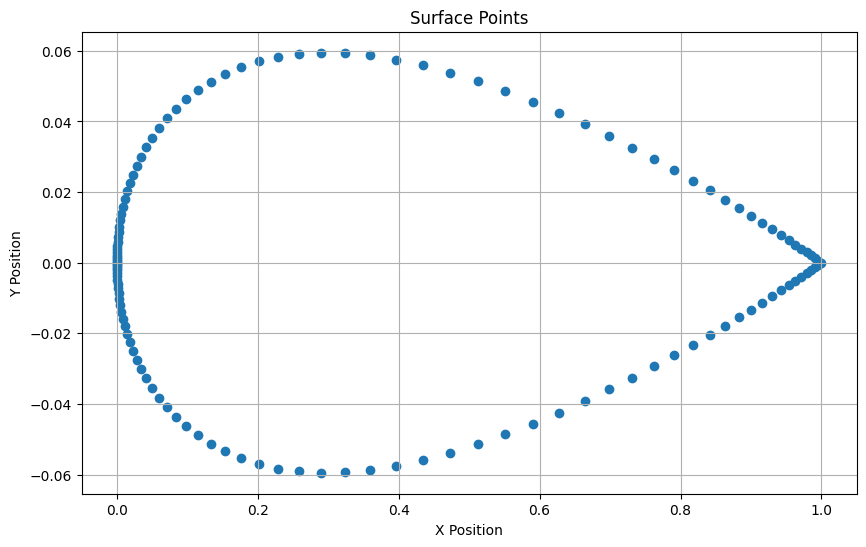

In [3]:
import matplotlib.pyplot as plt
surface_point = train_dataset[0].pos[surface_mask, :]
plt.figure(figsize=(10, 6))
plt.scatter(surface_point[:, 0].cpu().numpy(), surface_point[:, 1].cpu().numpy())
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Surface Points')
plt.grid(True)
plt.show()

## Training

In [4]:
data = train_dataset[0].to(device)
encoded_x = model.graph_encoder(data)
encoded_x.shape

torch.Size([14576, 16])

In [5]:
model.linear_autoencoder.encoder

Sequential(
  (encoder_layer_0): Linear(in_features=233216, out_features=2000, bias=True)
  (encoder_layer_0_ELU): ELU(alpha=1.0)
  (encoder_layer_1): Linear(in_features=2000, out_features=1000, bias=True)
  (encoder_layer_1_ELU): ELU(alpha=1.0)
  (encoder_layer_2): Linear(in_features=1000, out_features=200, bias=True)
  (encoder_layer_2_ELU): ELU(alpha=1.0)
  (encoder_layer_latent_dim): Linear(in_features=200, out_features=100, bias=True)
)

In [6]:
model.linear_autoencoder(encoded_x)

(tensor([ 0.1398, -0.0123,  0.0909,  0.0999,  0.0034,  0.0012,  0.0172, -0.0821,
          0.0584, -0.0713, -0.0885, -0.0254, -0.0267,  0.1475,  0.0416,  0.0243,
          0.1101,  0.1295, -0.0902,  0.0298, -0.0226, -0.1064, -0.0485,  0.0160,
         -0.0748,  0.0941, -0.0374,  0.2286, -0.1160,  0.0971,  0.0619,  0.0528,
          0.1111, -0.1725, -0.1396,  0.0077,  0.1580,  0.0730,  0.0147,  0.1781,
         -0.0188, -0.0942, -0.1695, -0.0387, -0.1021,  0.0452, -0.1723, -0.0370,
         -0.0228, -0.0093,  0.0535, -0.0710,  0.0216,  0.1427,  0.0107, -0.0548,
         -0.0768,  0.0474, -0.1204, -0.1195, -0.1413, -0.0811,  0.2270,  0.1207,
         -0.0967,  0.0485,  0.0326,  0.0759, -0.0033,  0.1489, -0.1677, -0.0803,
         -0.0125,  0.0160, -0.0594,  0.2185, -0.0421,  0.1046,  0.1362, -0.0318,
          0.1333, -0.0486, -0.1179, -0.0586, -0.1083,  0.0330,  0.0487,  0.1392,
         -0.0129, -0.0733,  0.1005,  0.0175, -0.1240,  0.0713, -0.1443,  0.0144,
         -0.0518, -0.0171,  

In [7]:
history = train(model = model, 
                device = device, 
                surface_mask = surface_mask,
                lambda_surface=1,
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                start_up_epoch=20,
                save_best_model=True,
                save_history=True,
                config = config['training'])

train_history, val_history = history

100%|██████████| 1000/1000 [3:51:44<00:00, 13.90s/it, train_loss=0.024464, map_loss=0.004798, reconstruction_loss=0.019667, val_loss=0.034893, val_reconstruction_loss=0.029346, val_map_loss=0.005547] 


In [8]:
from src.utils.commons import save_config
save_config(config, task='surface')

### Plot train total loss and val total loss

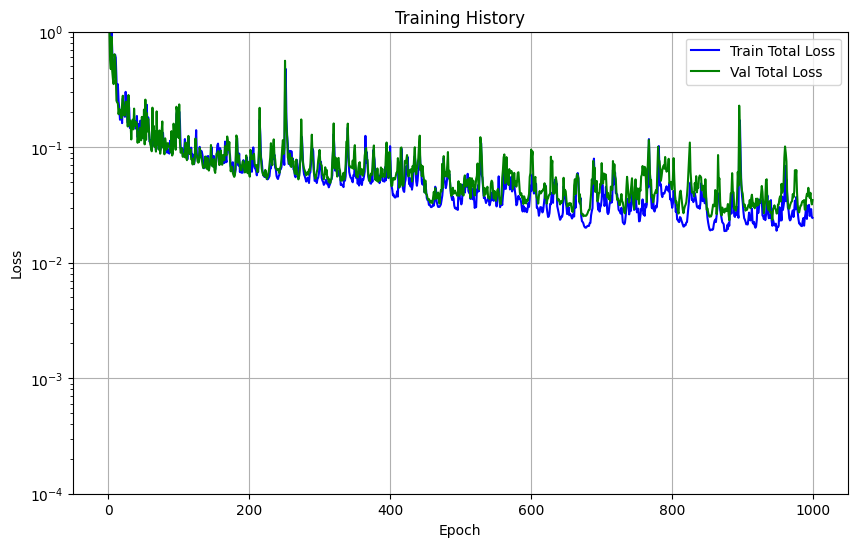

In [4]:
import pickle
import matplotlib.pyplot as plt
from src.utils.commons import get_config

config = get_config('configs/VEL_P_NACA0012.yaml')
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

with open(f"artifacts/surface/{model_name}/{model_name}_history_{num_epochs}.pkl", 'rb') as f:
    # Load the history dictionary
    train_history = pickle.load(f)
    val_history = pickle.load(f)
    
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']    

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot train loss history

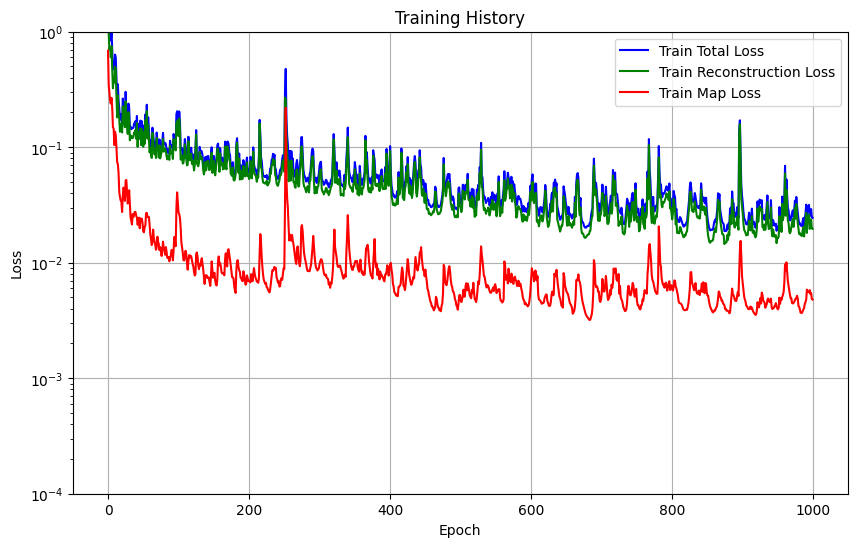

In [5]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot validation loss history

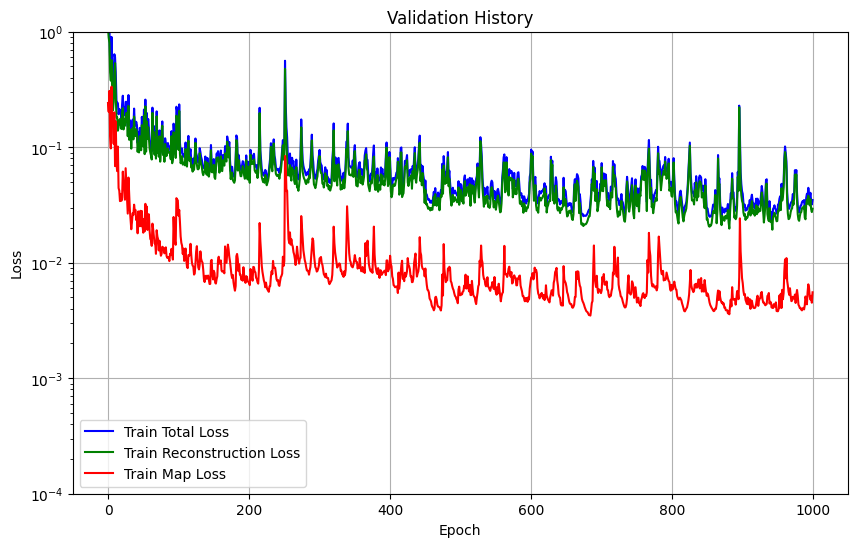

In [6]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Fine tuning mapping

In [ ]:
def fine_tune_mapping(model, train_loader, val_loader, device,
                      num_epochs=100, 
                      learning_rate=1e-3, 
                      weight_decay=1e-5, 
                      surface_mask=None):
    """
    Fine-tune the mapping layer of the model.
    """
    model.mapping.train()
    optimizer = torch.optim.AdamW(model.mapping.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0.0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            encoded_x = model.graph_encoder(data)
            latent_var_enc = model.linear_autoencoder.encoder(encoded_x)
            latent_var = model.mapping(data.params)
            
            loss = model.compute_loss(pred, data.y, surface_mask)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        
        # Validation step
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    latent_var = model.mapping(data.params)
                    decoded_x = model.linear_autoencoder.decoder(latent_var)
                    pred = model.graph_decoder(data, decoded_x.reshape([data.x.shape[0], -1]), is_verbose=False)
                    
                    loss = model.compute_loss(pred, data.y, surface_mask)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            print(f"Validation Loss: {avg_val_loss:.4f}")
    
    return model.mapping

## Plot results

### Matplotlib Plotting

In [2]:
from src.utils.plot import Plot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/VEL_P_NACA0012.yaml')
set_seed(config['config']['seed'])
num_epochs = config['training']['epochs']
model_name = config['training']['model_name']

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, ae_input_ize=train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])
model = model.to(device)
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

index = 27

test_plot_data = val_dataset[index].to(device)
test_param = test_plot_data.params

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data, test_param)
estimated_x = estimated_x.detach().cpu().numpy()

Original

    raw_velocities = np.array(grid.point_data[vtu_array_name], dtype=np.float32)
    raw_pressure = np.array(grid.point_data['Pressure'], dtype=np.float32)
    cp = np.array(grid['Pressure_Coefficient'], dtype=np.float32)
    cf = np.array(grid['Skin_Friction_Coefficient'], dtype=np.float32)[:,:2]
    Y_plus = np.array(grid['Y_Plus'], dtype=np.float32)
    nutilde = np.array(grid['Nu_Tilde'], dtype=np.float32)
    eddy_viscosity = np.array(grid['Eddy_Viscosity'], dtype=np.float32)

Using v_range: 3.3361692428588867


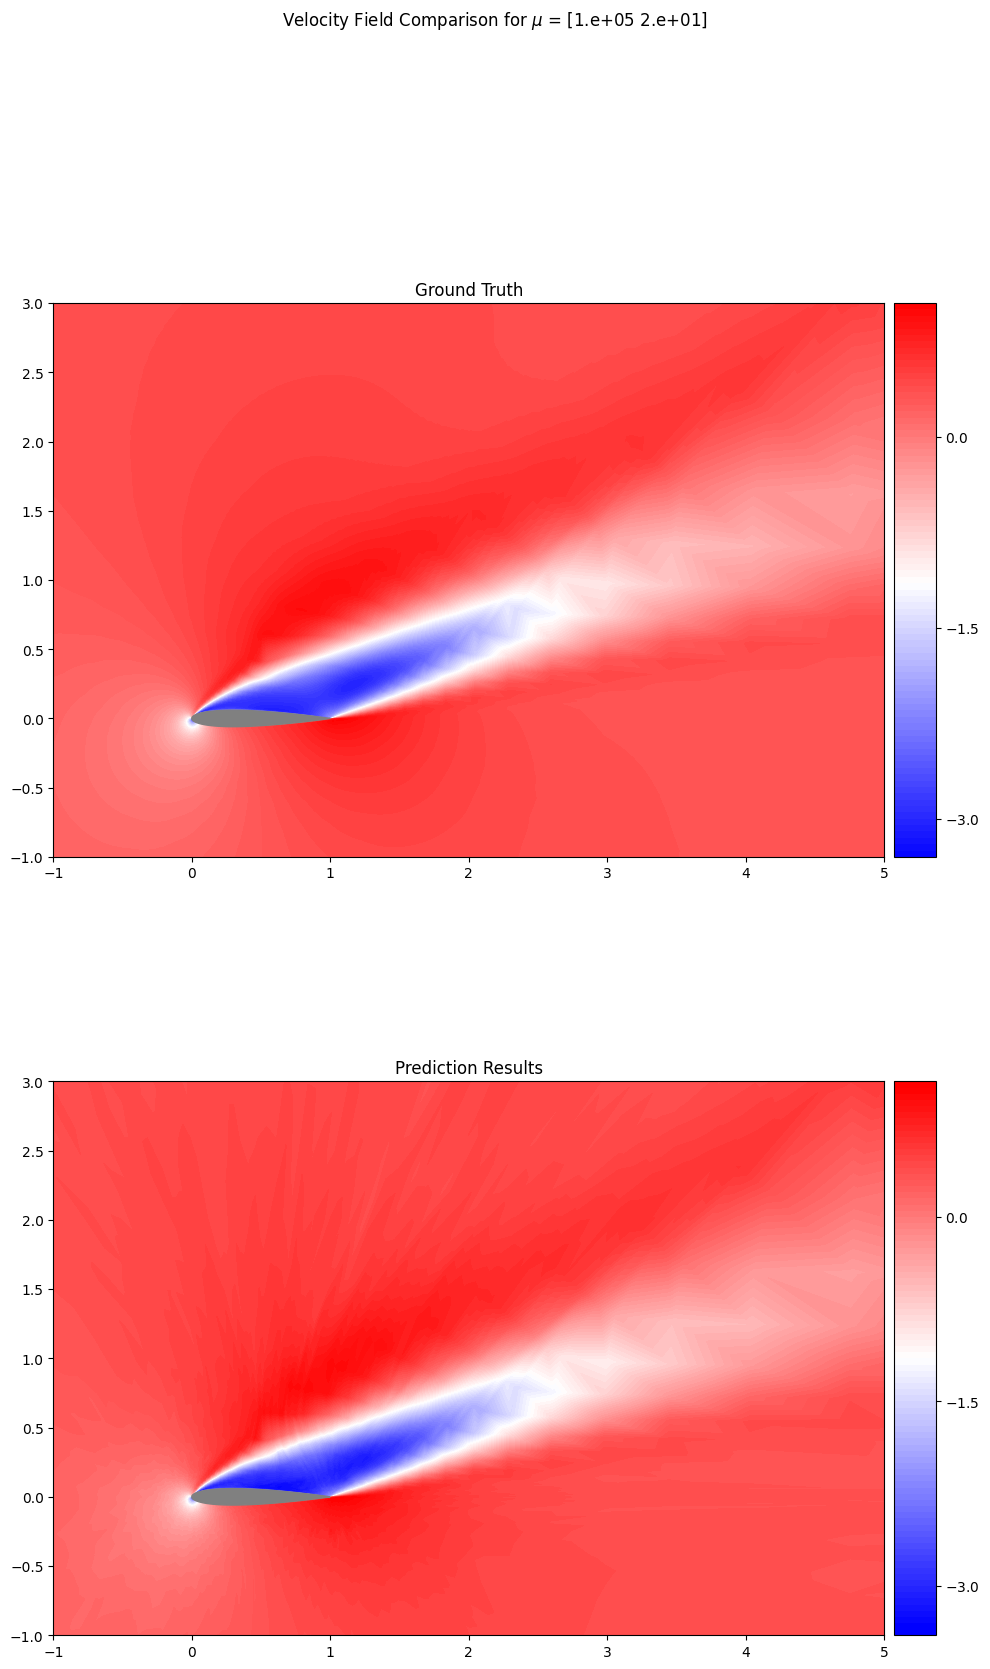

Using v_range: 3.3361690044403076


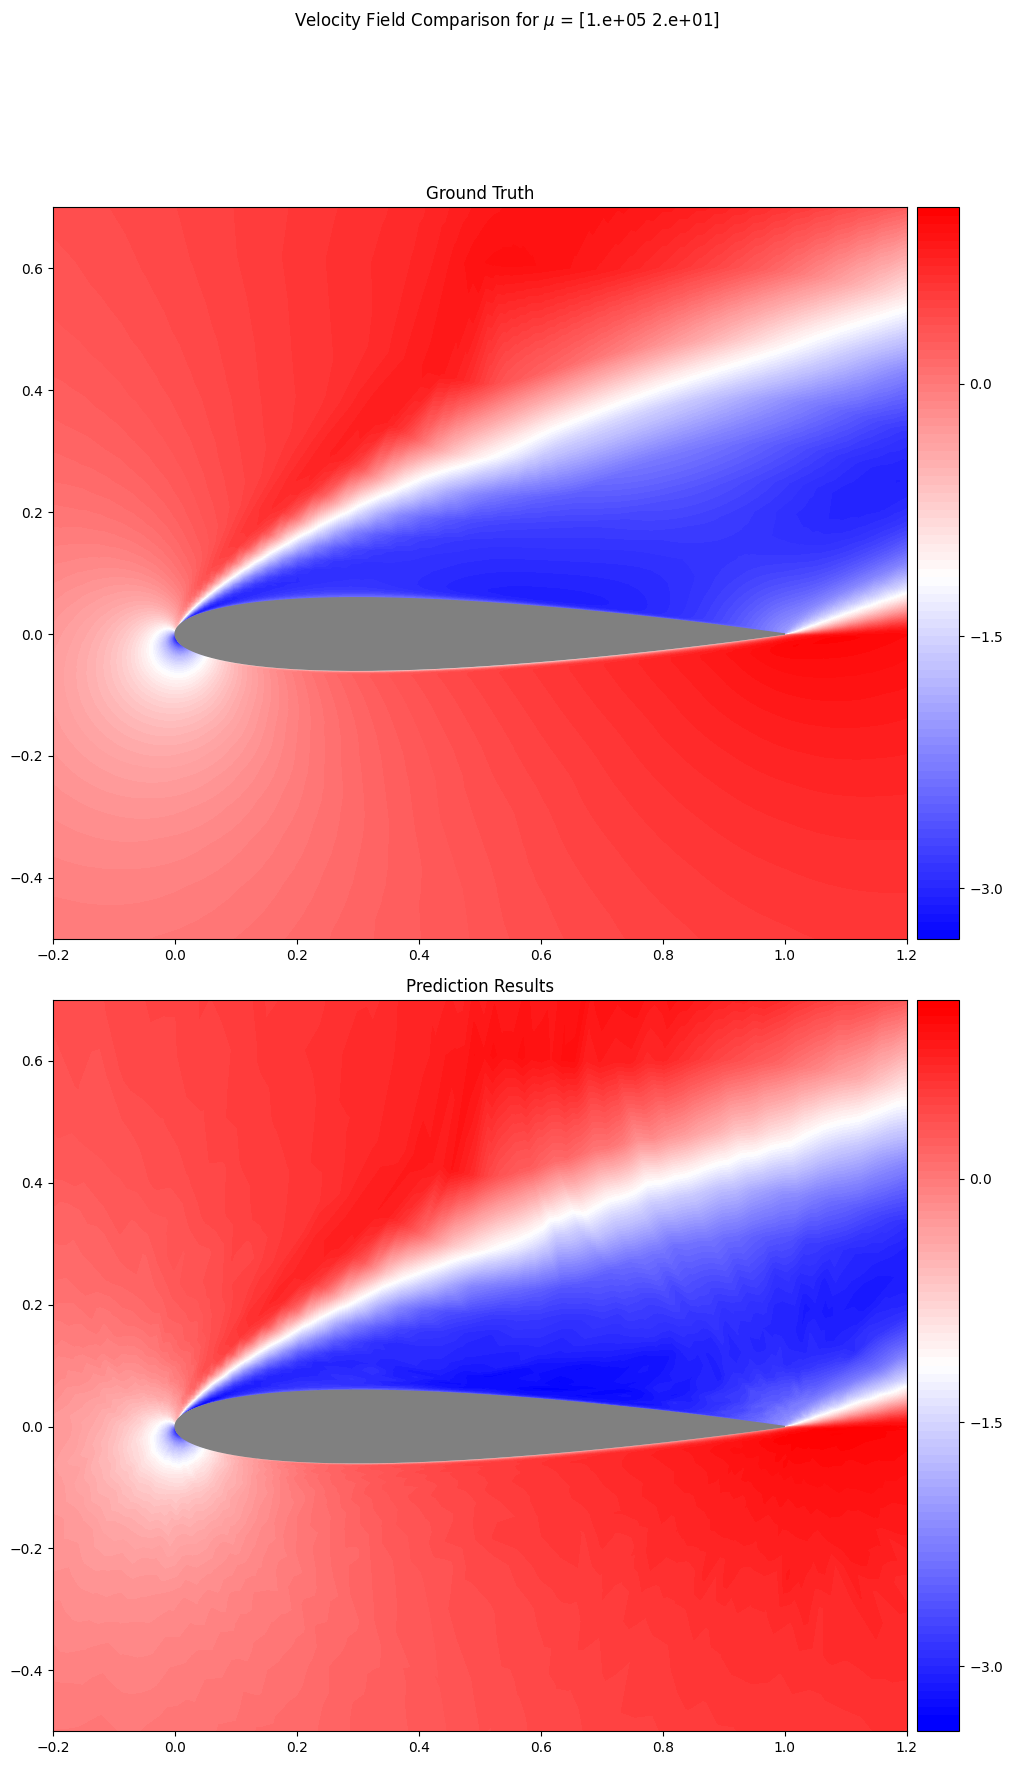

Using v_range: 4.818137168884277


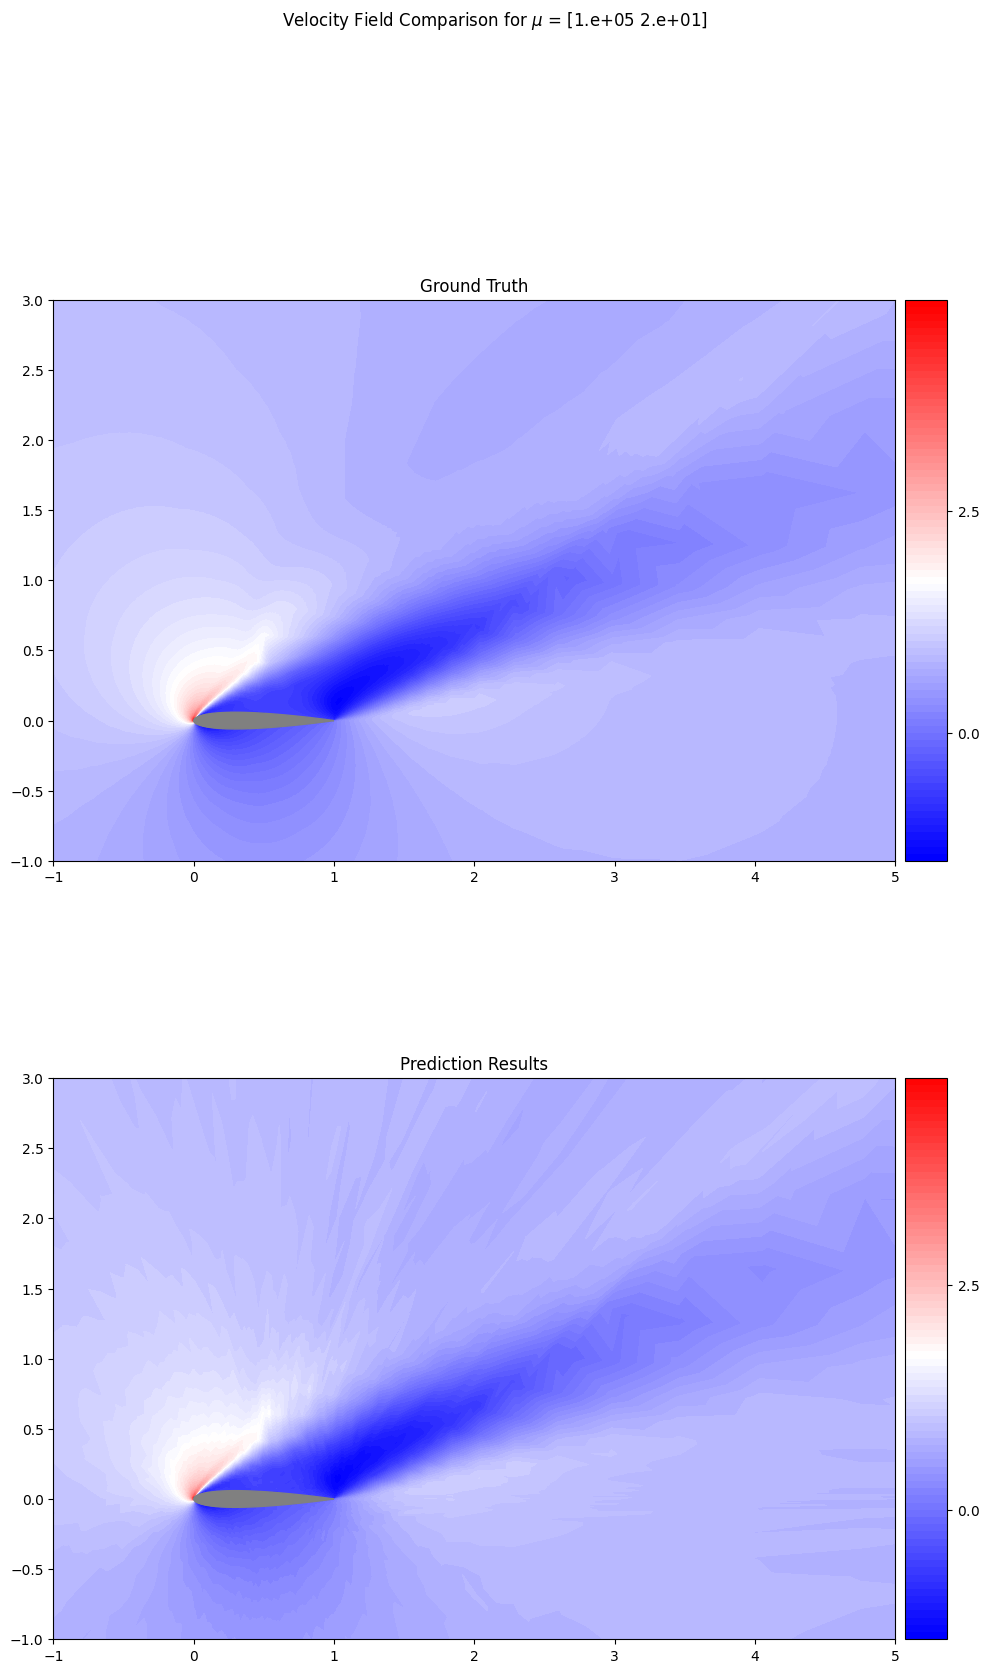

Using v_range: 4.818136692047119


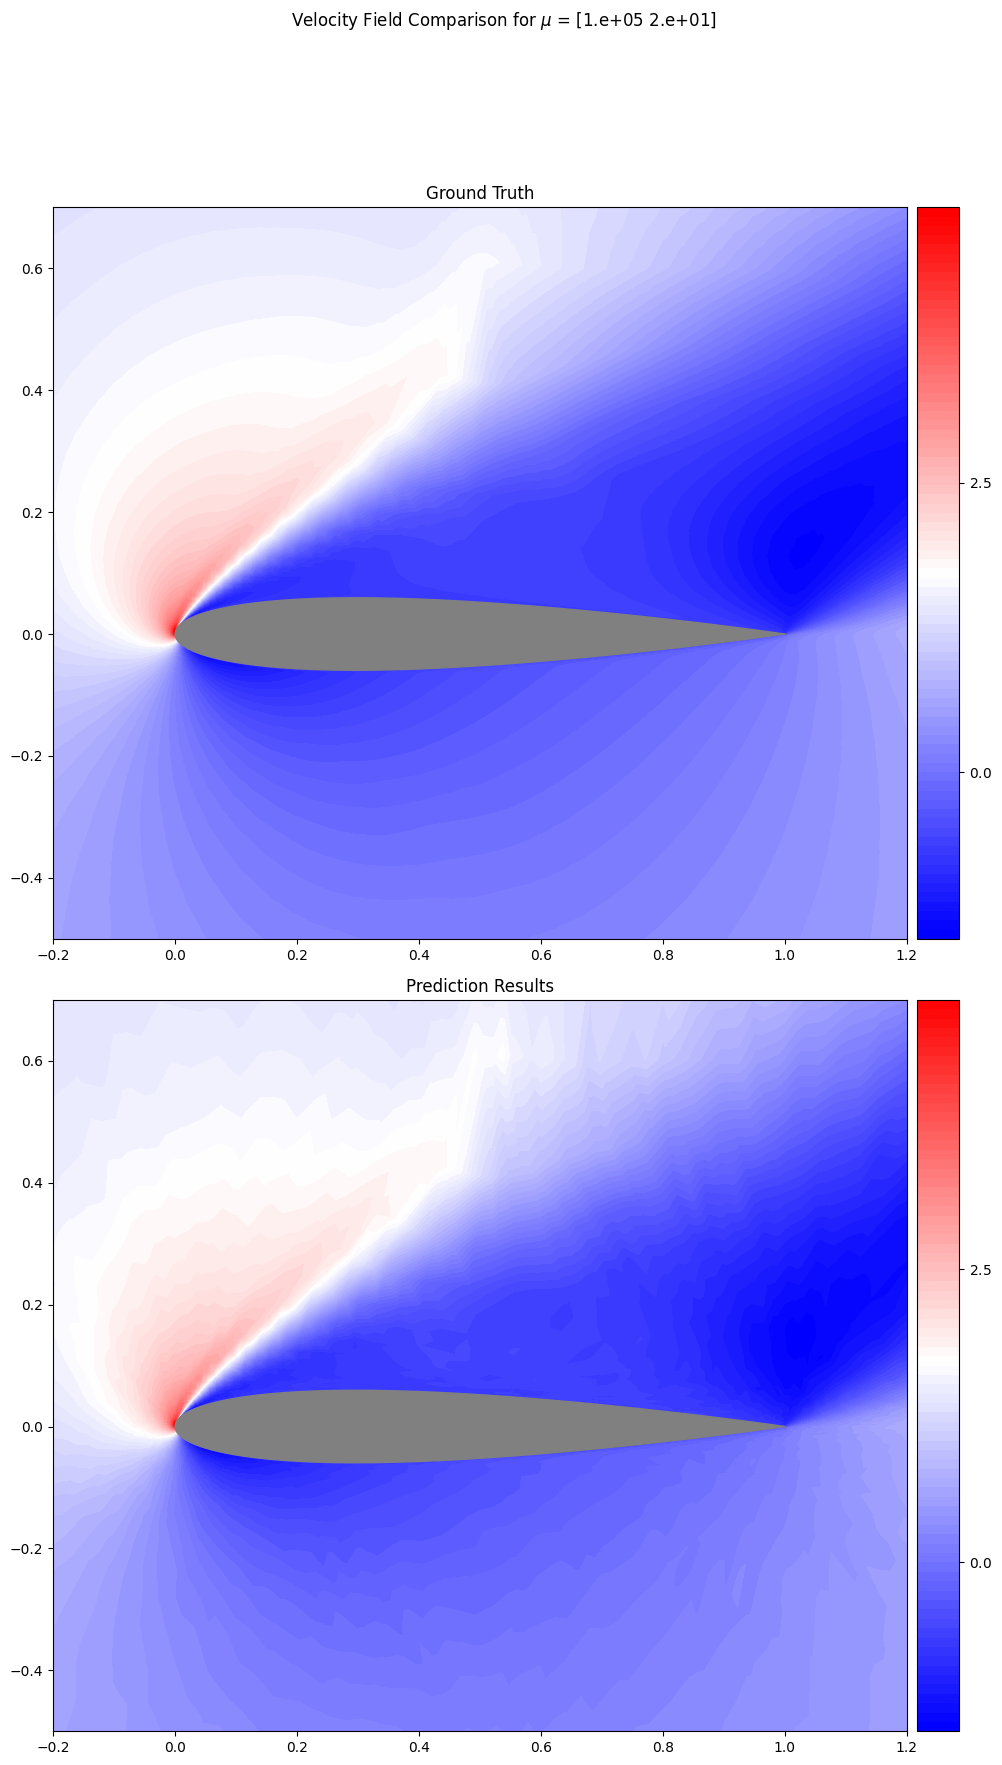

Using v_range: 1.9536328315734863


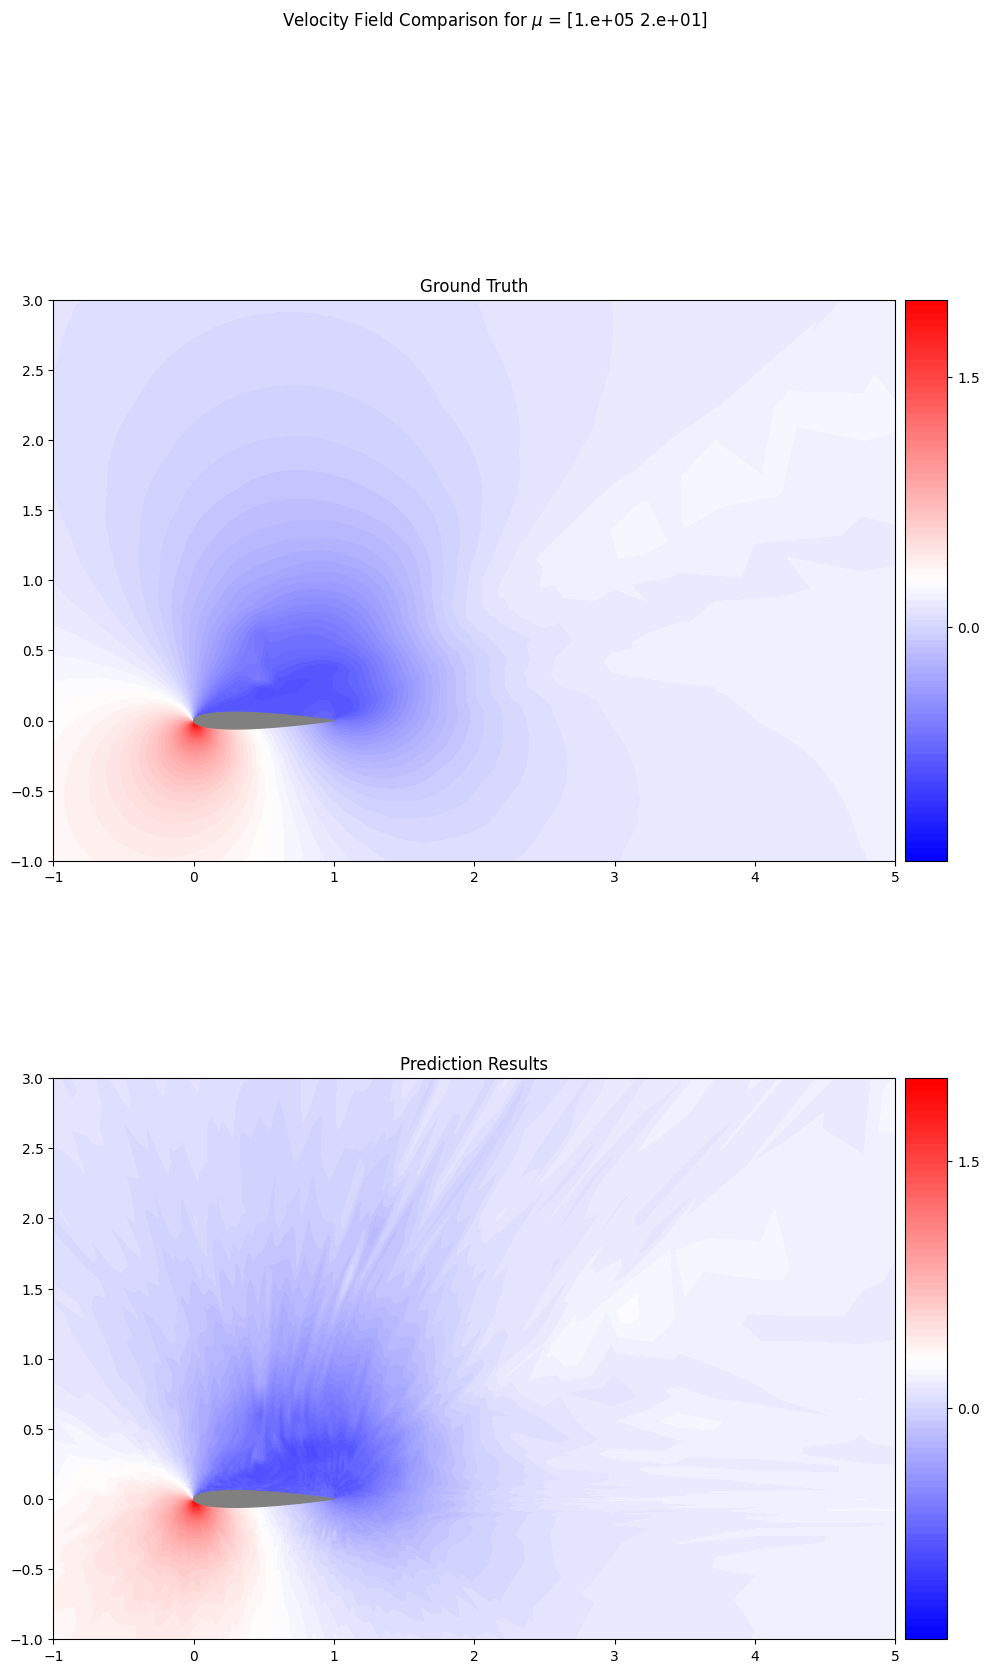

Using v_range: 1.9536325931549072


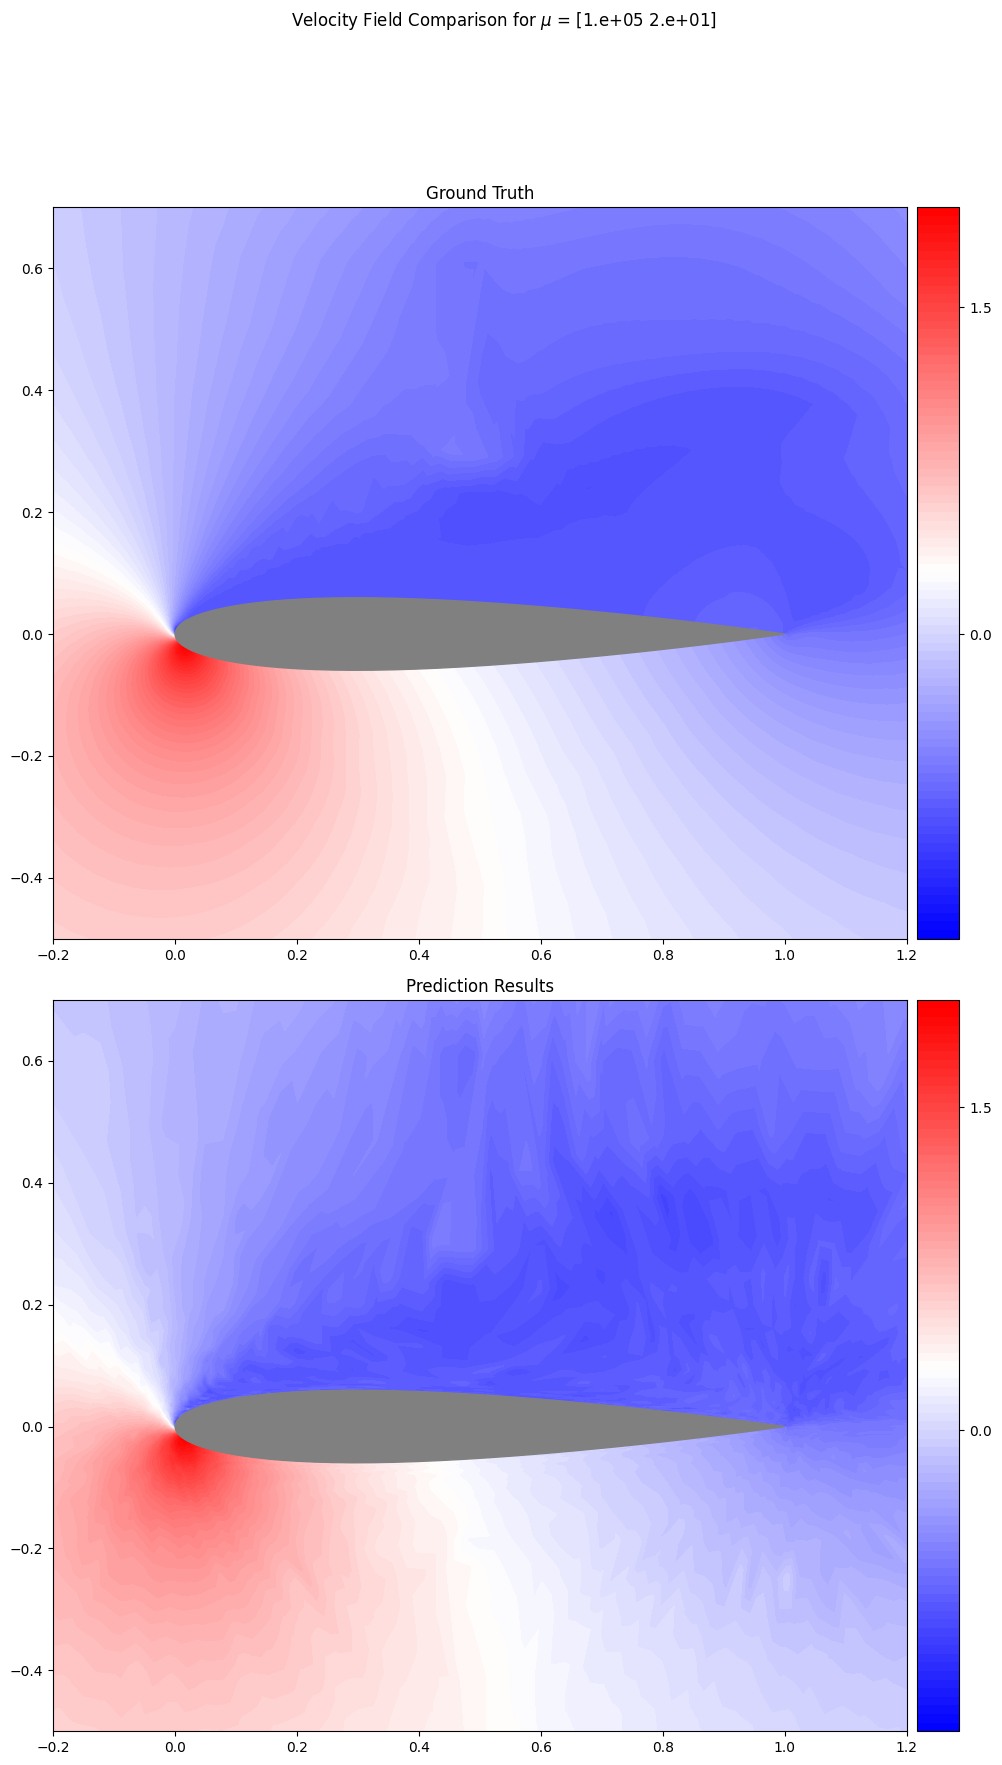

In [18]:
plot.plot_comparison_fields(SNAP = index, 
                            dim_index = 0, 
                            device = device, 
                            dataset = val_dataset, 
                            params = test_param, 
                            grid="vertical", colormap='bwr', 
                            xlim=[-1, 5], ylim=[-1, 3]
                            )

plot.plot_comparison_fields(SNAP = index, 
                            dim_index= 0,
                            device = device,
                            dataset = val_dataset, 
                            params = test_param, grid="vertical", 
                            colormap='bwr', 
                            # xlim=[-1, 5], ylim=[-1, 2]
                            xlim=[-0.2, 1.2], ylim=[-0.5, 0.7]
                            )

plot.plot_comparison_fields(SNAP = index, 
                            dim_index = 1, 
                            device = device, 
                            dataset = val_dataset, 
                            params = test_param, 
                            grid="vertical", colormap='bwr', 
                            xlim=[-1, 5], ylim=[-1, 3]
                            )

plot.plot_comparison_fields(SNAP = index, 
                            dim_index= 1,
                            device = device,
                            dataset = val_dataset, 
                            params = test_param, grid="vertical", 
                            colormap='bwr', 
                            # xlim=[-1, 5], ylim=[-1, 2]
                            xlim=[-0.2, 1.2], ylim=[-0.5, 0.7]
                            )

plot.plot_comparison_fields(SNAP = index, 
                            dim_index = 2, 
                            device = device, 
                            dataset = val_dataset, 
                            params = test_param, 
                            grid="vertical", colormap='bwr', 
                            xlim=[-1, 5], ylim=[-1, 3]
                            )

plot.plot_comparison_fields(SNAP = index, 
                            dim_index= 2,
                            device = device,
                            dataset = val_dataset, 
                            params = test_param, grid="vertical", 
                            colormap='bwr', 
                            # xlim=[-1, 5], ylim=[-1, 2]
                            xlim=[-0.2, 1.2], ylim=[-0.5, 0.7]
                            )

MSE Error

MSE error: 0.004291120916604996
Using v_range: 0.10243978351354599
Using v_range: 0.10243978351354599


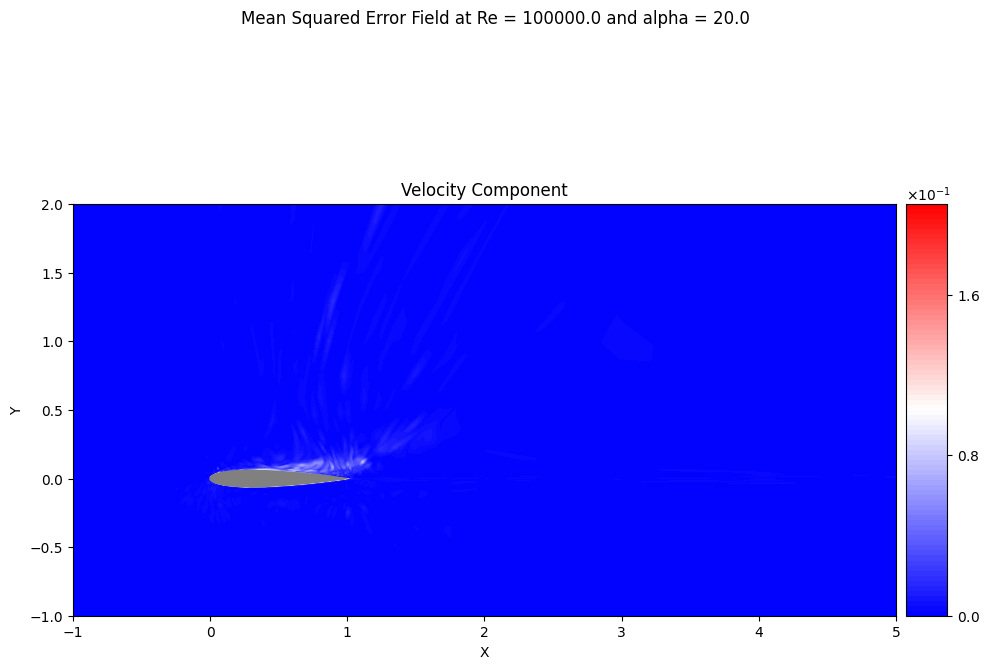

MSE error: 0.0017770349513739347
Using v_range: 0.208204448223114
Using v_range: 0.208204448223114


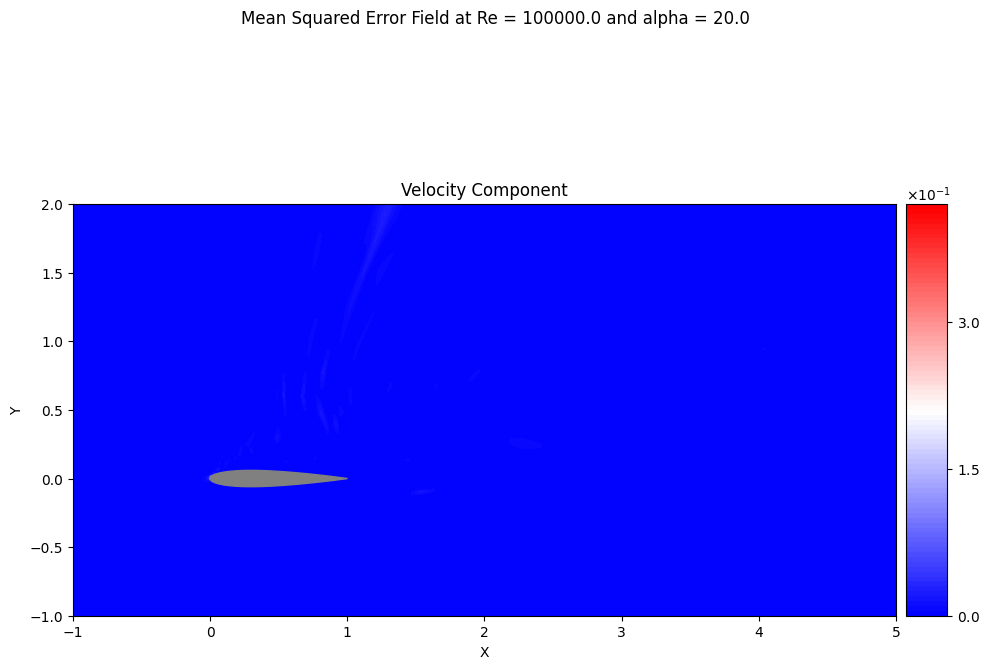

MSE error: 0.0009576879092492163
Using v_range: 0.06379222124814987
Using v_range: 0.06379222124814987


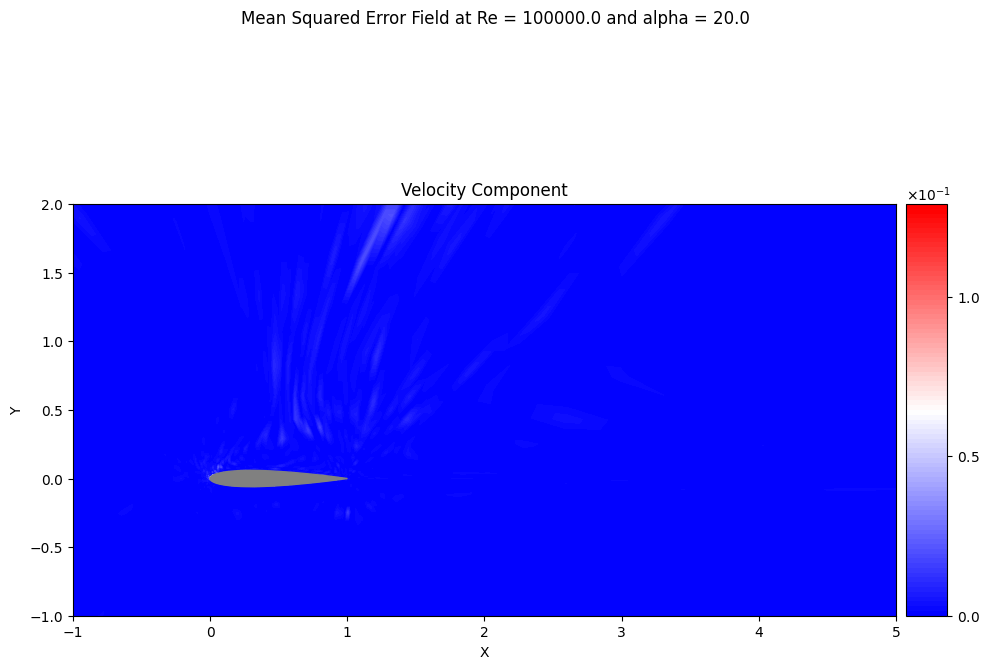

In [3]:
# v_range=[-0.17144335806369781, 0.17144335806369781]
# v_range = [0, 1e-2]
v_range = None
colormap='bwr'

# print(f"Ux MSE: {torch.nn.functional.msel(input=torch.tensor(estimated_x[:, 0]), target=torch.tensor(test_plot_data.y[:, 0].cpu().numpy()), reduction='mean')}")
plot.plot_velocity_field_error(data=test_plot_data,
                               dim_index = 0, 
                               params=test_param, device = device, 
                               title=f"Mean Squared Error Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=v_range,
                               xlim=[-1, 5], ylim=[-1, 2], 
                               colormap=colormap)

plot.plot_velocity_field_error(data=test_plot_data, 
                               dim_index = 1,
                               params=test_param, device = device, 
                               title=f"Mean Squared Error Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=v_range,
                               xlim=[-1, 5], ylim=[-1, 2],  
                               colormap=colormap)

plot.plot_velocity_field_error(data=test_plot_data, 
                               dim_index = 2,
                               params=test_param, device = device, 
                               title=f"Mean Squared Error Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=v_range,
                               xlim=[-1, 5], ylim=[-1, 2],  
                               colormap=colormap)

### Pyvista Plotting

In [ ]:
from src.utils.plot import PyvistaPlot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/VEL_P_NACA0012.yaml')
set_seed(config['config']['seed'])
num_epochs = config['training']['epochs']

test_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, num_graphs=test_dataset.num_graphs)
model = model.to(device)
plot = PyvistaPlot(vtu_dir = "dataset/flows", model=model, dataset=test_dataset)

In [ ]:
import pyvista as pv
index = 1
mesh = pv.read(f"dataset/flows/configuration_{index}.vtu")
mesh.clear_data()
mesh.point_data["Pressure"] = test_dataset[test_dataset.file_index.index(index)].x.detach().cpu().numpy()
mesh
# mesh.write_vtu("dataset/flows/configuration_0.vtu")

UnstructuredGrid (0x2648bc35300)
  N Cells:    14336
  N Points:   14576
  X Bounds:   -4.845e+02, 5.010e+02
  Y Bounds:   -5.078e+02, 5.078e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

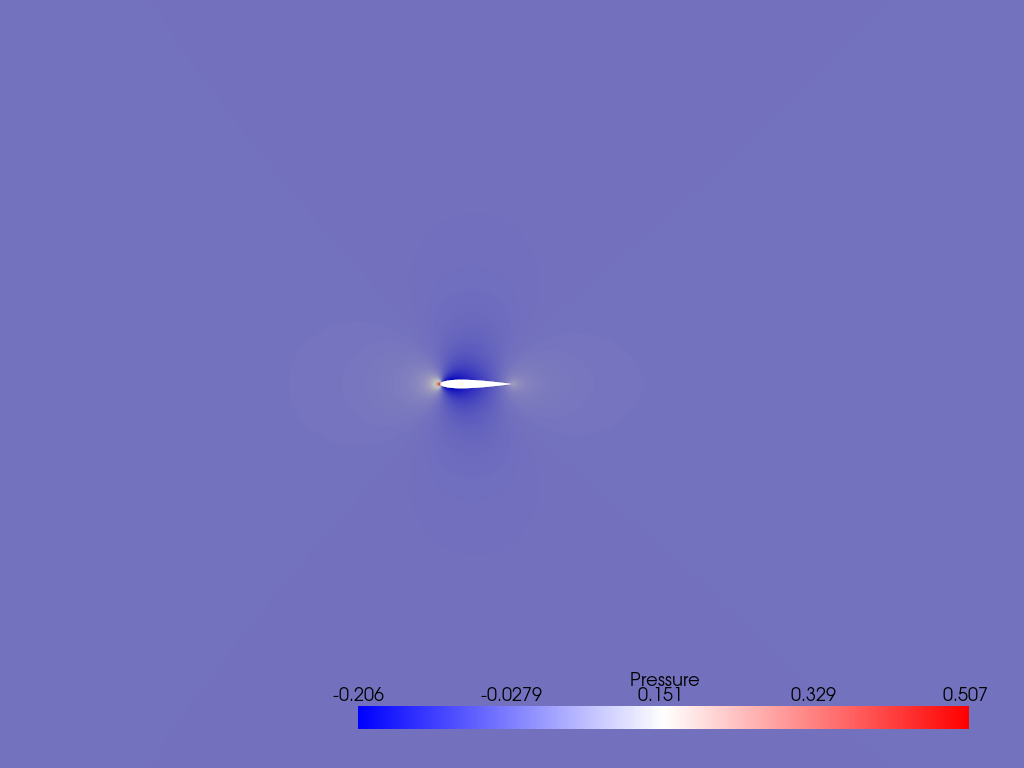

In [ ]:
plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars='Pressure', cmap='bwr')
plotter.view_xy()
# plotter.zoom_camera(1)
plotter.camera_position = [
    (0, 0, 20),   # camera location
    (1, 0, 0),      # focal point (center of the mesh)
    (0, 0, 0)       # view up vector (Z axis is "up")
]
plotter.legend()
# plotter.
# plotter.set_focal_point([0, 0, 0])
plotter.show()

# Post processing

In [3]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from torch_geometric.loader import DataLoader
from src.data.loader import GraphDataset
from src.utils.commons import get_config, load_model

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/VEL_P_NACA0012.yaml')
set_seed(config['config']['seed'])
device = get_device()
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

test_dataset = GraphDataset(config = config['config'], split = 'val')
test_loader = DataLoader(dataset=test_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])

surface_mask = test_dataset.surface_mask

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, ae_input_ize=test_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])
model = model.to(device)

from src.utils.metrics import mse_error, mae_error, rmse_error, relative_error
from src.training.test import test

error_func = [mse_error, mae_error, rmse_error, relative_error]
# test_params = params[test_dataset.file_index]
test_results, total_error = test(model, test_loader, device, error_func)
total_error

{'total_mse_error': 0.39182534721611,
 'total_mae_error': 0.2896856138896611,
 'total_rmse_error': 0.5735328850784788,
 'total_relative_error': 0.5438596247910971}

# Cp

Good: 5, 6
Hmm: 3, 4, 8
Bad: 1, 2, 9, 10, 11

In [ ]:
index = 5

MSE: 5.966353455733042e-08
Relative Error: 2.4929072424129117e-06


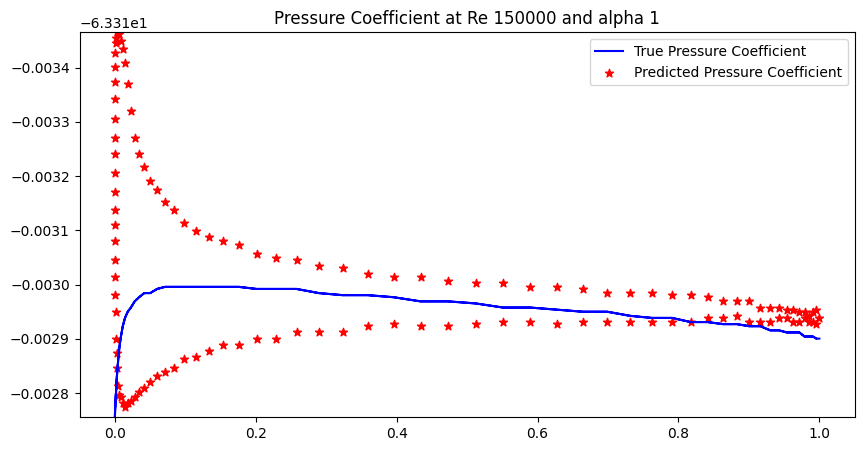

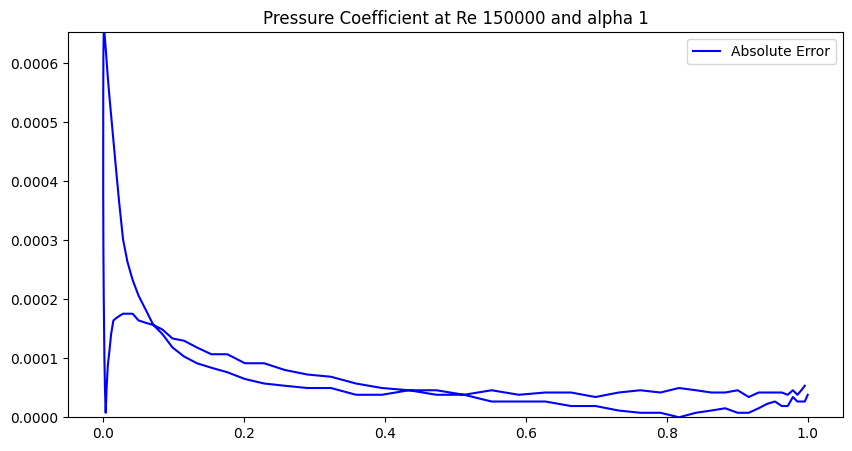

In [ ]:
from src.training.test import single_test

rho_inf = 2.13163
R = 287.058
T_inf = 300
viscosity_inf = 1.853e-05
v_inf = 52.1572 # THIS HAS TO BE CHANGED FOR EACH RE

p_inf = rho_inf * R * T_inf
q_inf = 0.5 * rho_inf * v_inf**2

model = model.to(device)
test_data = test_dataset[index]
test_data = test_data.to(device)
test_param = params[test_dataset.file_index[index]]
file_key = test_dataset.file_keys[0].split('_')[0] + '_' + str(test_dataset.file_index[index])
surface_mask = test_dataset.surface_mask
surface_point = test_data.pos[surface_mask].detach().cpu().numpy()
upper_surface_point = surface_point[surface_point[:, 1] >= 0]
lower_surface_point = surface_point[surface_point[:, 1] < 0]

# VTU FILE
# import pyvista as pv
# import meshio
# vtu_path = f"dataset/full/flow_Re_{int(test_param[0])}_alpha_{int(test_param[1])}.vtu"
# mesh_path = r"dataset/unsteady_naca0012.su2"
# grid = pv.read(vtu_path)
# surface_p = grid["Pressure"][surface_mask,]
# surface_cp = grid["Pressure_Coefficient"][surface_mask,]
# surface_p.shape

# truth
surface_p_graph = test_data.x[surface_mask].detach().cpu().numpy()
surface_cp_graph = test_dataset.h5_file[file_key]['Cp'][:][surface_mask]
surface_cp_graph = (surface_p_graph - p_inf) / q_inf
surface_p_graph.shape

#predicted
pred_p = single_test(model, test_param, test_data, device).detach().cpu().numpy()
surface_pred_p = pred_p[surface_mask,]
surface_pred_cp = (surface_pred_p - p_inf) / q_inf
surface_pred_p.shape

cp_mse = np.mean((surface_cp_graph - surface_pred_cp) ** 2)
print(f"MSE: {cp_mse}")
cp_relative = np.mean(np.abs(surface_pred_cp - surface_cp_graph) / np.abs(surface_cp_graph))
print(f"Relative Error: {cp_relative}")

plt.figure(figsize=(10, 5))
plt.plot(surface_point[:, 0], surface_cp_graph, label="True Pressure Coefficient", color="blue")
plt.scatter(surface_point[:, 0], surface_pred_cp, label="Predicted Pressure Coefficient", color="red", marker="*")
plt.ylim(max([max(surface_cp_graph), max(surface_pred_cp)]), min([min(surface_cp_graph), min(surface_pred_cp)]))
plt.title(f"Pressure Coefficient at Re {int(test_param[0])} and alpha {int(test_param[1])}")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(surface_point[:, 0], np.abs(surface_cp_graph - surface_pred_cp), label="Absolute Error", color="blue")
plt.ylim(0, max([max(np.abs(surface_cp_graph - surface_pred_cp))]))
plt.title(f"Pressure Coefficient at Re {int(test_param[0])} and alpha {int(test_param[1])}")
plt.legend()
plt.show()

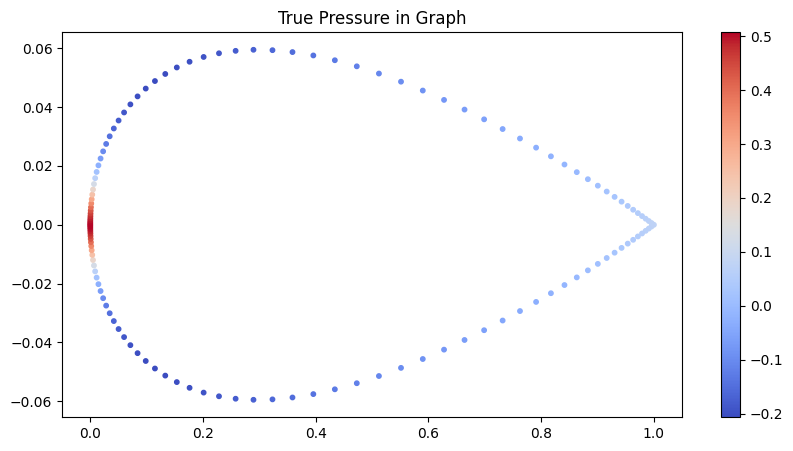

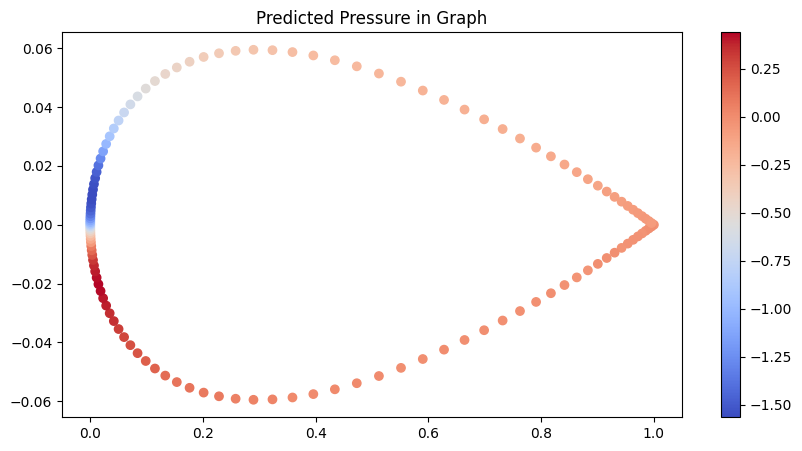

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_p_graph, cmap="coolwarm", s=10)
plt.colorbar()
plt.title("True Pressure in Graph")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_pred_p, cmap="coolwarm")
plt.colorbar()
plt.title("Predicted Pressure in Graph")
plt.show()

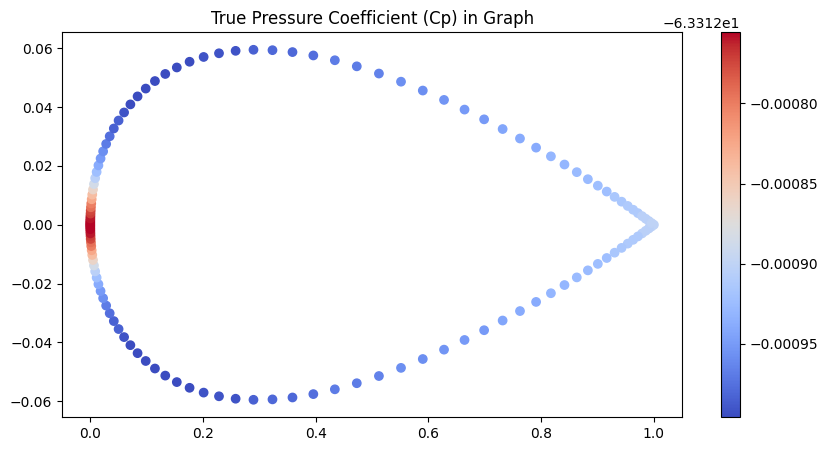

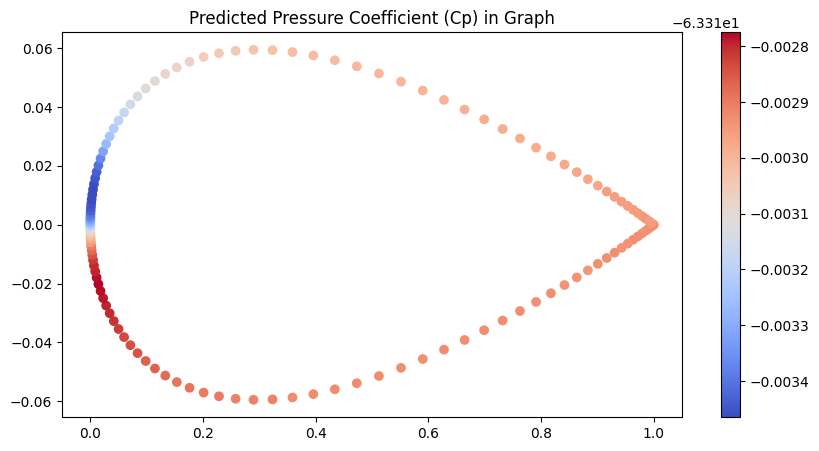

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_cp_graph, cmap="coolwarm")
plt.colorbar()
plt.title("True Pressure Coefficient (Cp) in Graph")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_pred_cp, cmap="coolwarm")
plt.colorbar()
plt.title("Predicted Pressure Coefficient (Cp) in Graph")
plt.show()